In [1]:
import altair as alt
import pandas
import numpy
import gzip
import json
import collections
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from IPython import display
from matplotlib import pyplot as plt

/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz

--2020-01-15 16:18:53--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95509687 (91M) [application/x-gzip]
Saving to: ‘reviews_Apps_for_Android_5.json.gz.4’

reviews_Apps_for_An 100%[===================>]  91.08M  17.2MB/s    in 8.1s    

2020-01-15 16:19:01 (11.2 MB/s) - ‘reviews_Apps_for_Android_5.json.gz.4’ saved [95509687/95509687]



In [2]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
def flatten_cols(df):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

pandas.DataFrame.flatten_cols = flatten_cols

In [4]:
def getDF(path):
    def parse(path):
        g = gzip.open(path, 'rb')
        for l in g:
            yield json.loads(l)
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pandas.DataFrame.from_dict(df, orient='index')

ratings = getDF("reviews_Apps_for_Android_5.json.gz")

In [5]:
ratings.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [6]:
ratings.head()

reviewerID        asin                   reviewerName helpful  \
0  A1N4O8VOJZTDVB  B004A9SDD8                 Annette Yancey  [1, 1]   
1  A2HQWU6HUKIEC7  B004A9SDD8        Audiobook lover "Kathy"  [0, 0]   
2  A1SXASF6GYG96I  B004A9SDD8                  Barbara Gibbs  [0, 0]   
3  A2B54P9ZDYH167  B004A9SDD8  Brooke Greenstreet "Babylove"  [3, 4]   
4   AFOFZDTX5UC6D  B004A9SDD8                     C. Galindo  [1, 1]   

                                          reviewText  overall  \
0  Loves the song, so he really couldn't wait to ...      3.0   
1  Oh, how my little grandson loves this app. He'...      5.0   
2  I found this at a perfect time since my daught...      5.0   
3  My 1 year old goes back to this game over and ...      5.0   
4  There are three different versions of the song...      5.0   

                                             summary  unixReviewTime  \
0                                        Really cute      1383350400   
1                                2-year-old loves it      1323043200   
2                                           Fun game      1337558400   
3                               We love our Monkeys!      1354752000   
4  This is my granddaughters favorite app on my K...      1391212800   

    reviewTime  
0   11 2, 2013  
1   12 5, 2011  
2  05 21, 2012  
3   12 6, 2012  
4   02 1, 2014

In [7]:
ratings.shape

(752937, 9)

In [8]:
ratings.drop(['reviewerName', 'helpful', 'reviewText',
       'summary', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [9]:
ratings.columns = ["user_id", "app_id", "rating"]

In [10]:
ratings.head()

user_id      app_id  rating
0  A1N4O8VOJZTDVB  B004A9SDD8     3.0
1  A2HQWU6HUKIEC7  B004A9SDD8     5.0
2  A1SXASF6GYG96I  B004A9SDD8     5.0
3  A2B54P9ZDYH167  B004A9SDD8     5.0
4   AFOFZDTX5UC6D  B004A9SDD8     5.0

In [11]:
user_app_num = ratings.nunique()

In [12]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']}).flatten_cols())

In [13]:
def hist(field, label, max_bins):
    base = alt.Chart().mark_bar().encode(x=alt.X(field, bin=alt.Bin(maxbins=max_bins), title=label),y="count()",).properties(width=300,)
    return alt.layer(base.encode(color=alt.value('blue'), opacity=alt.value(.7)),).resolve_scale(y='independent')

In [14]:
alt.hconcat(
    hist('rating_count', '# ratings / user', 20),
    hist('rating_mean', 'mean user rating', 10),
    data=users_ratings)

alt.HConcatChart(...)

In [15]:
users = pandas.unique(ratings.user_id)
ratings.user_id = ratings.user_id.map(pandas.Series(numpy.arange(len(users)), users))

In [16]:
apps = pandas.unique(ratings.app_id)
ratings.app_id = ratings.app_id.map(pandas.Series(numpy.arange(len(apps)), apps))

In [17]:
ratings

user_id  app_id  rating
0             0       0     3.0
1             1       0     5.0
2             2       0     5.0
3             3       0     5.0
4             4       0     5.0
...         ...     ...     ...
752932    77673   13208     5.0
752933    71533   13208     3.0
752934    51862   13208     4.0
752935    53162   13208     5.0
752936    15450   13208     4.0

[752937 rows x 3 columns]

In [18]:
def build_rating_sparse_tensor(ratings_df):
    indices = ratings_df[['user_id', 'app_id']].values
    values = ratings_df['rating'].values
    return tf.SparseTensor(indices=indices, 
                           values=values, 
                           dense_shape=[user_app_num["user_id"], user_app_num["app_id"]]
                          )

In [19]:
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [20]:
def mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [21]:
# Matrix Factorization Model

class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
              optimizer=tf.train.GradientDescentOptimizer):
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(tf.variables_initializer(opt.variables()),tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(["%s=%f" % (k, v) for r in results for k, v in r.items()]),end='')
                iterations.append(i)
                for metric_val, result in zip(metrics_vals, results):
                    for k, v in result.items():
                        metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

In [22]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    train_ratings, test_ratings = split_dataframe(ratings)
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    U = tf.Variable(tf.random.normal([A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal([A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = mean_square_error(A_train, U, V)
    test_loss = mean_square_error(A_test, U, V)
    metrics = {'train_error': train_loss,'test_error': test_loss}
    embeddings = {"user_id": U, "app_id": V}
    return CFModel(embeddings, train_loss, [metrics])

In [24]:
model = build_model(ratings, embedding_dim=150, init_stddev=0.05)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 iteration 5000: train_error=0.020934, test_error=2.371283

[{'test_error': 2.3712833, 'train_error': 0.020933744}]

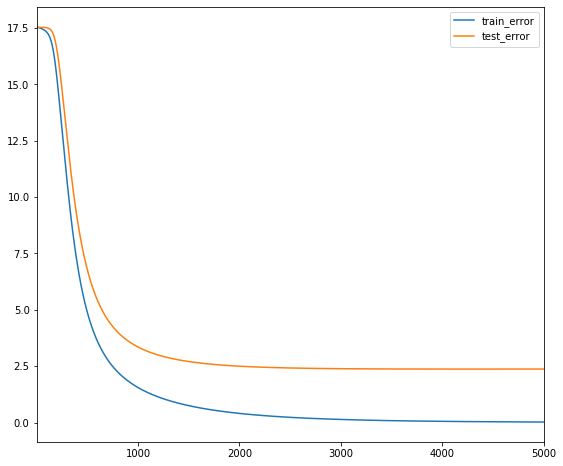

In [25]:
model.train(num_iterations=5000, learning_rate=20.0)

In [23]:
# Regularized Matrix Factorization Model

def gravity(U, V):
    return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
        tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,init_stddev=0.1):
    train_ratings, test_ratings = split_dataframe(ratings)
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    error_train = mean_square_error(A_train, U, V)
    error_test = mean_square_error(A_test, U, V)
    gravity_loss = gravity_coeff * gravity(U, V)
    regularization_loss = regularization_coeff * (
          tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
    total_loss = error_train + regularization_loss + gravity_loss
    losses = {
          'train_error_observed': error_train,
          'test_error_observed': error_test,
      }
    loss_components = {
          'observed_loss': error_train,
          'regularization_loss': regularization_loss,
          'gravity_loss': gravity_loss,
      }
    embeddings = {"user_id": U, "movie_id": V}

    return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 1500: train_error_observed=1.700297, test_error_observed=5.239820, observed_loss=1.700297, regularization_loss=0.699763, gravity_loss=0.941158

[{'test_error_observed': 5.23982, 'train_error_observed': 1.7002965},
 {'gravity_loss': 0.9411578,
  'observed_loss': 1.7002965,
  'regularization_loss': 0.6997631}]

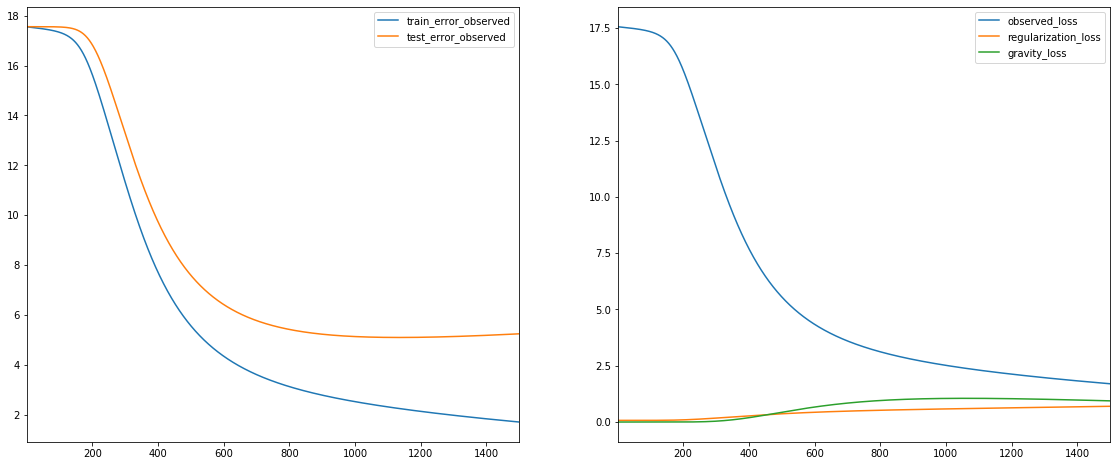

In [27]:
reg_model = build_regularized_model(ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=150, init_stddev=.05)
reg_model.train(num_iterations=1500, learning_rate=20.)